# 実践コンピュータビジョン
# 7章 画像検索
## 7.4 データベースの画像を検索する
テキストp.161

画像にインデックス付けしたので、データベースから類似画像を検索することができる。  
Searcherクラスを使って、検索処理を行う。

In [2]:
from PIL import Image
import pickle
# from pylab import *
%matplotlib inline

In [3]:
import imtools

import sift
import imagesearch

### 7.4.1 インデックスを用いて候補を取得する
特定のワードを含むすべての画像を見つけるために、インデックスを活用する。  
imagesearch.py内に定義したSearcherクラスのcandidates_from_word()メソッドを使う。

In [4]:
# ファイル名のリストを作成する
imlist = sorted(imtools.get_imlist('first1000'))
nbr_images = len(imlist)
featlist = [ imlist[i][:-3]+'sift' for i in range(nbr_images)]

# ボキャブラリを読み込む
with open('vocabulary.pkl', 'rb') as f:
    voc = pickle.load(f)

In [5]:
src = imagesearch.Searcher('test.db',voc)
locs,descr = sift.read_features_from_file(featlist[0])
iw = voc.project(descr)

In [6]:
print('ask using a histogram...')
print(src.candidates_from_histogram(iw)[:10])

ask using a histogram...
[817, 823, 822, 96, 77, 871, 656, 653, 80, 886]


### 7.4.2 画像を用いて問い合わせる
続いて画像をクエリとして全件検索を行うため、imagesearch.py内のquery()メソッドのうち、  
get_imshitogram()メソッドを使って、画像のワードヒストグラムを返す。

In [7]:
print('try a query...')
print(src.query(imlist[0])[:10])

try a query...
[(0.0, 1), (64.707032075347115, 2), (66.340033162487941, 3), (84.504437753291981, 560), (86.660256173173181, 677), (86.666025638654972, 4), (87.304066342868595, 659), (87.772433029966763, 670), (88.096537956948112, 664), (88.487287222515761, 719)]


### get_imhistogram()の変更点
上記ではquery()の呼び出しで、get_imhistogram()を使っており、  
その中でpickle.loads()を使っている。ここでPython 3.xはバイナリを入力するので、    
書き換えが必要。str()を使わないので、s[0]を直接入力する。

```python
def get_imhistogram(self,imname):  
    """ 画像のワードヒストグラムを返す """  
    im_id = self.con.execute(  
      "select rowid from imlist where filename='%s'" % imname).fetchone()  
    s = self.con.execute(  
      "select histogram from imhistograms where rowid='%d'" % im_id).fetchone()  

    # pickleを使って文字列をNumPy配列に変換する  
    # python 3.xではpickle.loads()に文字列ではなく、バイナリを入力する  
    return pickle.loads(str(s[0]))　 # 修正前  
    return pickle.loads((s[0]))     # 修正後
```

### 7.4.3 ベンチマークを測定し結果を描画する
検索結果を評価するため、上位4件のうち正しい画像の数を計算する。  
計算にはimagesearch.compute_ukbench_score()を用いる。  
処理に時間がかかるため、１０件のみを処理する。<br>
また参考のため、処理時間を計測する。

In [8]:
import time

In [9]:
# 10件の処理
t0 = time.time()
score = imagesearch.compute_ukbench_score(src,imlist[:10])
t1 = time.time()
print('processing time [sec]:', t1-t0)
print('score:', score)

processing time [sec]: 18.247542142868042
score: 3.3


### 検索結果の表示
imagesearch.plot_results()を使用して、検索結果の画像を表示する

### imagesearch.plot_results()
画像検索結果を表示する関数。
notebookで実行するには、"%matplotlib inline"が必要。

```python
def plot_results(src,res):
    """ 検索結果リスト'res'の画像を表示する """
    figure(figsize=(10,10))
    nbr_results = len(res)
    for i in range(nbr_results):
        imname = src.get_filename(res[i])
        subplot(1,nbr_results,i+1)
        imshow(array(Image.open(imname)))
        axis('off')
    show()
```

In [12]:
nbr_results = 5
res = [w[1] for w in src.query(imlist[0])[:nbr_results]]
res

[1, 2, 3, 560, 677]

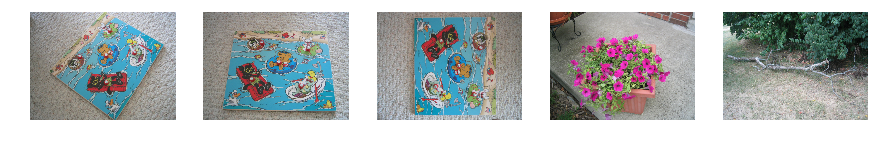

In [13]:
imagesearch.plot_results(src, res)

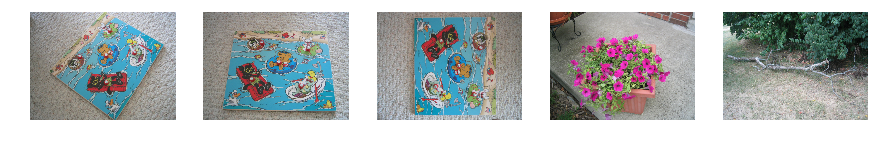

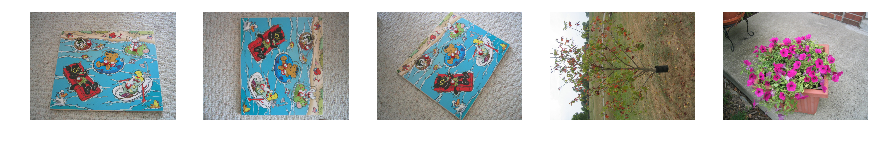

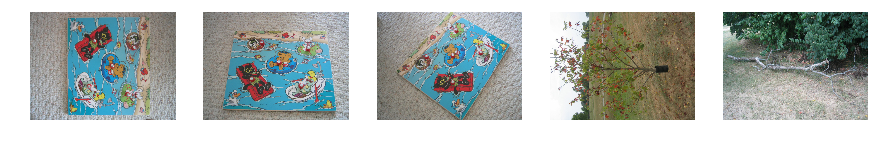

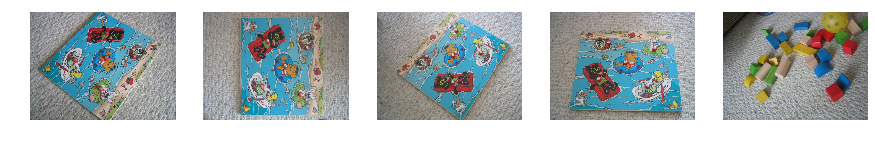

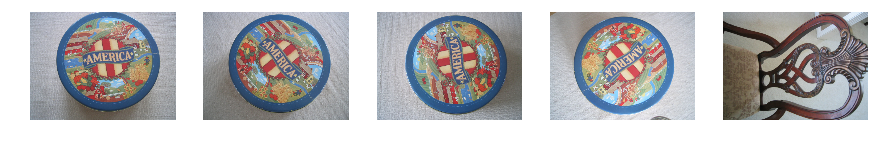

In [14]:
# imlistの最初の５枚に関して、画像検索結果を表示する
for i in range(5):
    res = [w[1] for w in src.query(imlist[i])[:nbr_results]]
    imagesearch.plot_results(src, res)

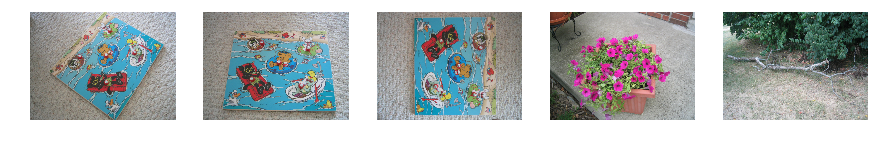

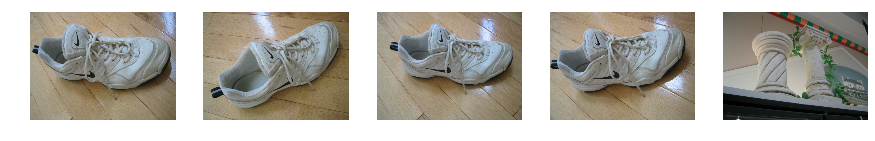

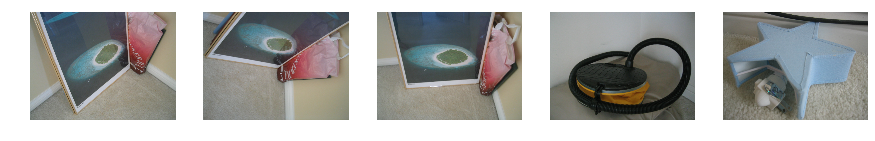

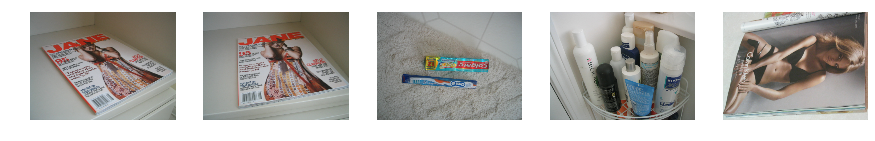

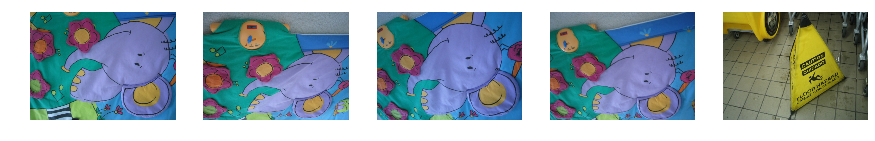

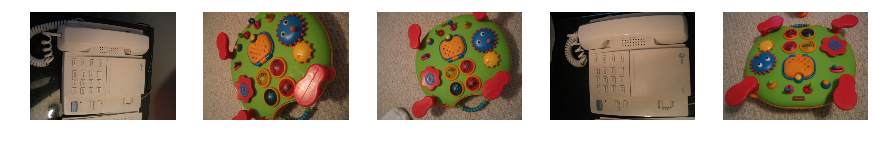

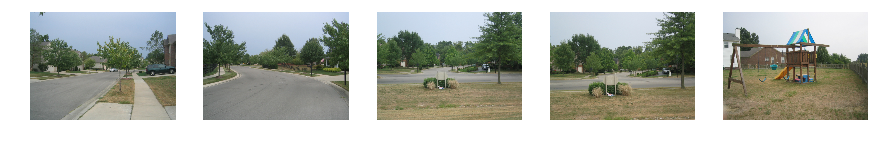

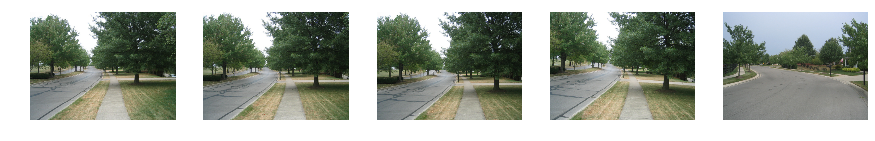

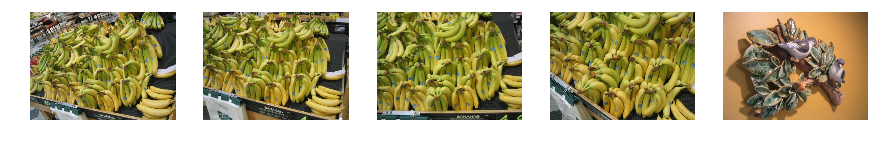

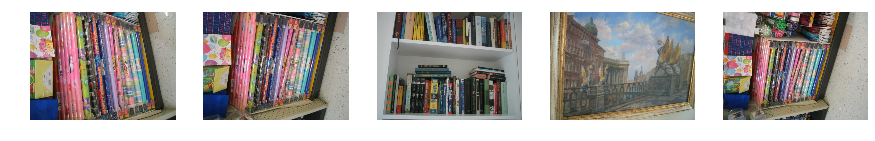

In [15]:
# １００番置きに検索した結果
for im in imlist[::100]:
    res = [w[1] for w in src.query(im)[:nbr_results]]
    imagesearch.plot_results(src, res)

In [16]:
# imlist, featlistをpickleで保存する
with open('ukbench_imlist.pkl','wb') as f:
    pickle.dump(imlist, f)
    pickle.dump(featlist, f)